# 1) Imports

In [59]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [60]:
from os import walk
from os.path import join, exists
from utils import nomes, save_dataframe_as_feather, decode_rle

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [61]:
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN, OPTICS, KMeans, AgglomerativeClustering

import tensorflow
from tensorflow.keras.preprocessing import image

# 2) Carregar dataset

In [62]:
dataset = pd.read_feather('train_com_imagens.feather')
dataset = dataset.sample(frac=1)
dataset

,id,class,segmentation,image,width,height
51465,case117_day0_slice_0101,large_bowel,19807 11 20065 22 20326 29 20590 31 20854 34 2...,.\train\case117\case117_day0\scans\slice_0101_...,266,266
99325,case36_day8_slice_0130,small_bowel,None,.\train\case36\case36_day8\scans\slice_0130_26...,266,266
14375,case42_day0_slice_0108,stomach,18484 7 18493 3 18748 17 18779 8 19012 20 1904...,.\train\case42\case42_day0\scans\slice_0108_26...,266,266
38870,case19_day18_slice_0014,large_bowel,None,.\train\case19\case19_day18\scans\slice_0014_3...,360,310
106796,case154_day13_slice_0121,small_bowel,None,.\train\case154\case154_day13\scans\slice_0121...,266,266
...,...,...,...,...,...,...
60229,case43_day26_slice_0118,large_bowel,None,.\train\case43\case43_day26\scans\slice_0118_2...,266,266
2226,case11_day12_slice_0069,stomach,35861 15 36219 19 36577 23 36936 25 37295 27 3...,.\train\case11\case11_day12\scans\slice_0069_3...,360,310
72090,case41_day25_slice_0141,large_bowel,None,.\train\case41\case41_day25\scans\slice_0141_2...,266,266
57964,case136_day25_slice_0143,large_bowel,None,.\train\case136\case136_day25\scans\slice_0143...,360,310


# 3) Clusterizar imagens p/ gerar exemplos de teste

In [82]:
distancia_vizinho = 1
n_vizinhos = 25

def new_cluster_model():
	# Demora menos mas consumo de memória é n
	# return DBSCAN(
	# 	eps=distancia_vizinho,
	# 	min_samples=n_vizinhos,
	# 	n_jobs=-2
	# )

	return KMeans(
		n_clusters=10,
	)

	# Demora consideravelmente mas não consome tanta memória
	# return OPTICS(
	# 	cluster_method='dbscan',
	# 	eps=distancia_vizinho,
	# 	min_samples=n_vizinhos,
	# 	n_jobs=-2
	# )

	# Demora + consumo de memória
	# return AgglomerativeClustering(
	# 	n_clusters=10,
	# )

In [83]:
# largura, altura = 100, 100


class Counter:
    _count = 0
    @staticmethod
    def get():
        Counter._count += 1
        return Counter._count
    
    @staticmethod
    def reset():
        Counter._count = 0


cluster_model = new_cluster_model()

def clustering(linha):
    img = image.load_img(
        linha['image'],
        target_size=(linha['width'], linha['height']),
        color_mode='grayscale'
    )

    # Para realizar o clustering de uma imagem
    # Precisa de uma matriz das posicoes + uma dimensao para cores
    image_as_arr = image.img_to_array(img).reshape(linha['width'] * linha['height'], 1)

    print(Counter.get(), end=', ')
    
    return cluster_model.fit_predict(image_as_arr)

In [84]:
# Limitar os dados por questão de tempo
# limite_dados = 10000
# limite_dados = 1000
# limite_dados = 100
limite_dados = 25

df_dados = pd.concat([
	dataset[dataset['class'] == 'stomach'].sample(limite_dados),
	dataset[dataset['class'] == 'small_bowel'].sample(limite_dados),
	dataset[dataset['class'] == 'large_bowel'].sample(limite_dados),
])

df_dados['class'].value_counts()

df_dados['clusters'] = df_dados.apply(clustering, axis=1)
df_dados.head()

1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 

,id,class,segmentation,image,width,height,clusters
15846,case114_day15_slice_0117,stomach,None,.\train\case114\case114_day15\scans\slice_0117...,360,310,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ..."
53704,case123_day22_slice_0102,stomach,None,.\train\case123\case123_day22\scans\slice_0102...,266,266,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
25585,case121_day16_slice_0144,stomach,None,.\train\case121\case121_day16\scans\slice_0144...,266,266,"[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, ..."
92920,case66_day34_slice_0098,stomach,17709 2 17971 10 18234 14 18497 18 18762 20 19...,.\train\case66\case66_day34\scans\slice_0098_2...,266,266,"[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ..."
72000,case63_day0_slice_0096,stomach,28582 7 28846 12 29111 15 29377 18 29643 22 29...,.\train\case63\case63_day0\scans\slice_0096_26...,266,266,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


## Visualização

Número clusters: 9
Tem segmentação: True
(266, 266) (266, 266)


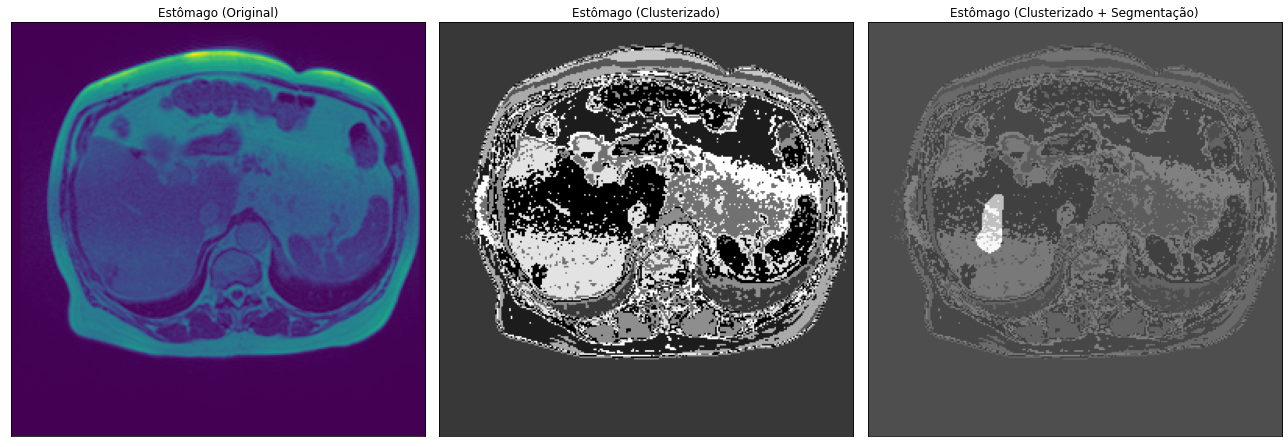

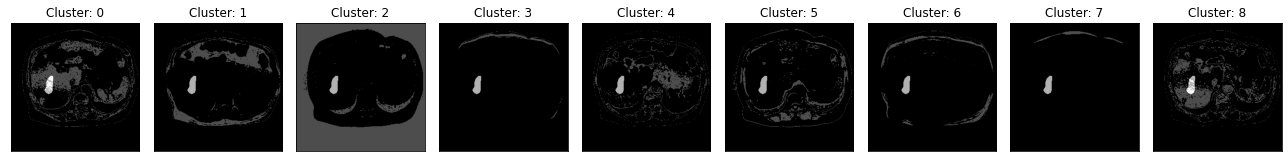

In [88]:
linha = df_dados[df_dados['segmentation'].notnull()].sample(n=1).iloc[0]

print('Número clusters:', max(linha['clusters']))
print('Tem segmentação:', bool(linha['segmentation']))

# Desenhar
fig = plt.figure(figsize=(18, 10))
fig.patch.set_alpha(1)

ax = plt.subplot(1, 3, 1)
# ax.imshow(image.load_img(linha['image'], target_size=(linha['height'], linha['width'])))
ax.imshow(plt.imread(linha['image']))
plt.xticks([])
plt.yticks([])
plt.title(nomes[linha['class']] + ' (Original)')

ax = plt.subplot(1, 3, 2)
clusters = linha['clusters'].reshape(linha['width'], linha['height'])
ax.imshow(clusters, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title(nomes[linha['class']] + ' (Clusterizado)')
plt.tight_layout()

if linha['segmentation']:
	ax = plt.subplot(1, 3, 3)

	ax.imshow(clusters, cmap='gray', alpha=0.5)

	segmentation = linha['segmentation']
	segmentation_rle = decode_rle(segmentation, shape=(linha['height'], linha['width']))

	# if clusters.shape[0] != segmentation_rle.shape[0] and clusters.shape[1] != segmentation_rle.shape[1]:
	# 	print('>', clusters.shape, segmentation_rle.shape)
	# 	segmentation_rle = segmentation_rle.reshape(clusters.shape[0], clusters.shape[1])

	print(clusters.shape, segmentation_rle.shape)
	ax.imshow(segmentation_rle, cmap='gray', alpha=0.5)
	plt.xticks([])
	plt.yticks([])
	plt.title(nomes[linha['class']] + ' (Clusterizado + Segmentação)')

	plt.tight_layout()

plt.show()

max_clusters = min(max(linha['clusters']), 50)
fig, axs = plt.subplots(1, max_clusters, figsize=(max_clusters * 2, 6))
fig.patch.set_alpha(1)
for i in range(max_clusters):
	cluster_selecionado = i
	d = pd.DataFrame(linha['clusters']).applymap(lambda x: 1 if x == cluster_selecionado else 0)
	d = np.array(d.values).reshape(linha['width'], linha['height'])
	axs[i].imshow(d, cmap='gray')
	axs[i].imshow(segmentation_rle, cmap='gray', alpha=0.7)
	axs[i].set_title(f'Cluster: {cluster_selecionado}')
	axs[i].set_xticks([])
	axs[i].set_yticks([])

plt.tight_layout()

# plt.title(nomes[linha['class']] + ' (Segmentado)')
# plt.show()

In [67]:
# save_dataframe_as_feather(df_dados, 'train_imagens_clusters.feather')